In [25]:

import pandas as pd
import psycopg2
import dotenv
import os

dotenv.load_dotenv()

# PG_PASSWORD = "_KjE6\2_JX0UGTJdZYl"
# PG_USER = "busit_87"
# PG_HOST = "fuji.ucll.be"
# PG_PORT = "52425"
# PG_DATABASE = "international_week"

# PG_PASSWORD = os.getenv("PG_PASSWORD")
# PG_USER = os.getenv("PG_USER")
# PG_HOST = os.getenv("PG_HOST")
# PG_PORT = os.getenv("PG_PORT")
# PG_DATABASE = os.getenv("PG_DB")

PG_PASSWORD = os.getenv("PG_PASSWORD", "_KjE6\\2_JX0UGTJdZYl")
PG_USER = os.getenv("PG_USER", "busit_87")
PG_HOST = os.getenv("PG_HOST", "fuji.ucll.be")
PG_PORT = os.getenv("PG_PORT", "52425")
PG_DATABASE = os.getenv("PG_DB", "international_week")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="allow",
)

# Query to fetch tracking data
query = """
SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
JOIN teams t ON p.team_id = t.team_id
WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
"""
tracking_df = pd.read_sql_query(query, conn)
tracking_df.head()

,frame_id,timestamp,player_id,x,y,jersey_number,player_name,team_id
0,1722799204000,00:05:04,pi2sxs616a52jvpfywgwjowl,46.591803,82.008591,22,G. Ruyssen,4dtif7outbuivua8umbwegoo5
1,1722799204000,00:05:04,60gs7lod7de72ypcs6qfup8q2,53.204590,50.845902,9,A. Guðjohnsen,8y3iucyxguipljcmf87a11bk9
2,1722799204000,00:05:04,3r04y1fejoh9e8qbge3exy3u1,21.321672,2.013952,22,N. Fadiga,8y3iucyxguipljcmf87a11bk9
3,1722799204000,00:05:04,dxcsuw39xzusjsj5e1jw53y6t,77.095147,49.095082,34,M. Verrips,4dtif7outbuivua8umbwegoo5
4,1722799204000,00:05:04,863wevd1kdzq5sd7qpmhr4lqs,30.326181,13.390267,88,F. Ferraro,4dtif7outbuivua8umbwegoo5


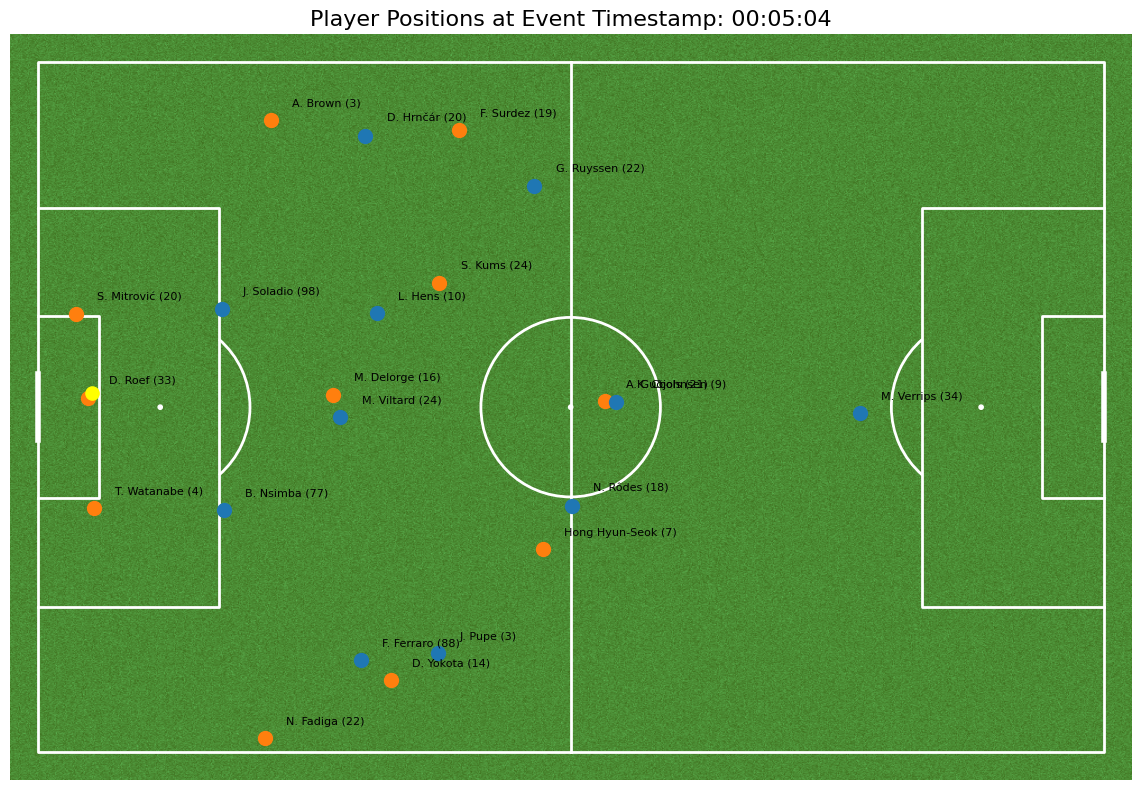

In [26]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib as mpl

def plot_tracking_data(tracking_data):
    # Define pitch dimensions and colors
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
                  pitch_length=105, pitch_width=68)  # Adjust dimensions if necessary
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Extract timestamp and team names
    timestamp = tracking_data['timestamp'].iloc[0]
    team_names = tracking_data['team_id'].unique()
    colors = mpl.colors.TABLEAU_COLORS
    color_map = {team: color for team, color in zip(team_names, colors.values())}
    
    # Plot player positions
    for _, row in tracking_data.iterrows():
        x = row['x']
        y = row['y']
        player_name = row['player_name']
        team_name = row['team_id']
        jersey_no = row['jersey_number']
        
        # Plot the ball
        if row['player_name'] == 'Ball':
            pitch.scatter(x, y, s=90, color='yellow', ax=ax, label='Ball')
        else:
            # Plot players
            pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax, label=team_name)
        
        # Add player names (excluding the ball)
        if row['player_name'] != 'Ball':
            ax.text(x + 2, y + 2, f"{player_name} ({jersey_no})", fontsize=8)
    
    # Set title
    ax.set_title(f'Player Positions at Event Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
frame_id = tracking_df['frame_id'].unique()[0]  
# You can change this to any specific frame_id you want to visualize
filtered_tracking_df = tracking_df[tracking_df['frame_id'] == frame_id]

if filtered_tracking_df.empty:
    print(f"No data found for frame_id: {frame_id}")
else:
    plot_tracking_data(filtered_tracking_df)

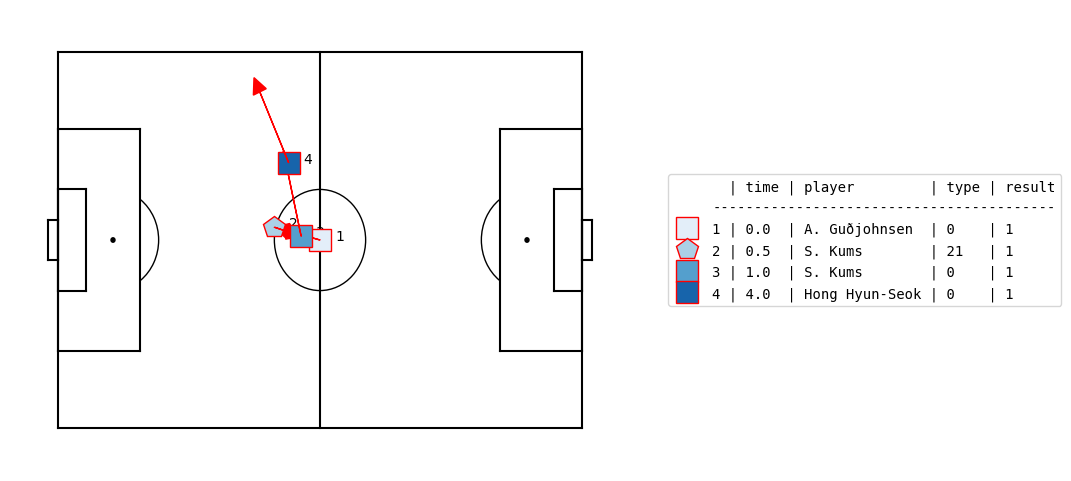

None

In [27]:
import matplotsoccer

query = """
SELECT 
    s.id, 
    s.game_id, 
    s.period_id, 
    s.seconds, 
    s.team_id, 
    s.player_id, 
    s.action_type, 
    s.bodypart,
    s.start_x, 
    s.start_y, 
    s.end_x, 
    s.end_y, 
    s.result,
    p.player_name,
    t.team_name
FROM spadl_actions s
JOIN players p ON s.player_id = p.player_id
JOIN teams t ON s.team_id = t.team_id
WHERE s.game_id = '5uts2s7fl98clqz8uymaazehg'
ORDER BY s.id;
"""

spadl_df = pd.read_sql_query(query, conn)

# First get 3 random spadl actions that follow each other
spadl_actions = spadl_df.iloc[0:4]

ax = matplotsoccer.actions(
    location=spadl_actions[["start_x", "start_y", "end_x", "end_y"]],
    action_type=spadl_actions.action_type,
    team=spadl_actions.team_name,
    result=spadl_actions.result == "success",
    label= spadl_actions[["seconds", "player_name", "action_type", "result"]]
,
    labeltitle=["time", "player", "type", "result"],
    zoom=False,
    figsize=8,
)
display(ax)

# the plot shows the actions in the order they are in the dataframe, so you can see how the game evolves over time.


In [28]:

complex_query = """
-- Explain: This CTE selects all actions from the spadl_actions table for a specific game and adds previous and next team IDs to each action.
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        spadl_actions a
    WHERE
        a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

-- Explain: This CTE identifies the start of a new possession by checking if the current team_id is different from the previous one.
possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM
        action_changes
),

-- Explain: This CTE assigns a unique possession group to each sequence of actions by the same team. This displays the number of actions in each possession.
possession_sequences AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM
        possession_markers
),

-- Explain: This CTE aggregates the actions by possession group and team_id to count the number of actions in each possession.
-- Different from the previous query because it counts the number of actions in each possession, whereas the previous one only counted the number of actions per team.
possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM
        possession_sequences
    GROUP BY
        possession_group, team_id
)

-- Explain: This final query selects the relevant columns from the possession_sequences CTE and joins with possession_stats to get the action count for each possession.
-- Find possession-ending actions where team had 3+ consecutive actions
SELECT
    a.id AS action_id,
    a.game_id,
    a.period_id,
    a.seconds AS time_seconds,
    p.player_name,
    t.team_name AS team_losing_possession,
    nt.team_name AS team_gaining_possession,
    a.action_type AS type_name,
    a.result AS result_name,
    ps.action_count AS consecutive_team_actions,
    a.start_x,
    a.start_y,
    a.end_x,
    a.end_y,
    a.id AS original_event_id
FROM
    possession_sequences a
JOIN
    possession_stats ps ON a.possession_group = ps.possession_group 
                                            AND a.team_id = ps.team_id
                                            AND a.id = ps.last_action_id  
JOIN
    players p ON a.player_id = p.player_id
JOIN
    teams t ON a.team_id = t.team_id
LEFT JOIN
    teams nt ON a.next_team_id = nt.team_id
WHERE
    ps.action_count >= 3  
    AND a.team_id != a.next_team_id  
    AND a.next_team_id IS NOT NULL  
ORDER BY
    a.period_id,
    a.seconds,
    a.id;
"""

# Execute the complex query
possession_df = pd.read_sql_query(complex_query, conn)
print(f"Loaded {len(possession_df)} possession-ending actions")
display(possession_df.head())
# table will show the actions that ended a possession, with the team that lost the ball and the team that gained it.


Loaded 223 possession-ending actions


,action_id,game_id,period_id,time_seconds,player_name,team_losing_possession,team_gaining_possession,type_name,result_name,consecutive_team_actions,start_x,start_y,end_x,end_y,original_event_id
0,25146,5uts2s7fl98clqz8uymaazehg,1,22.0,A. Brown,Gent,Dender,0,1,13,51.345,60.656,71.715,65.280,25146
1,25160,5uts2s7fl98clqz8uymaazehg,1,48.0,D. Roef,Gent,Dender,0,0,13,7.665,35.292,39.480,63.852,25160
2,25163,5uts2s7fl98clqz8uymaazehg,1,55.0,B. Nsimba,Dender,Gent,0,0,3,40.425,59.296,40.425,68.000,25163
3,25168,5uts2s7fl98clqz8uymaazehg,1,66.0,A. Brown,Gent,Dender,0,0,5,39.795,67.116,42.210,68.000,25168
4,25173,5uts2s7fl98clqz8uymaazehg,1,87.0,F. Ferraro,Dender,Gent,0,1,5,57.855,5.644,40.110,4.624,25173


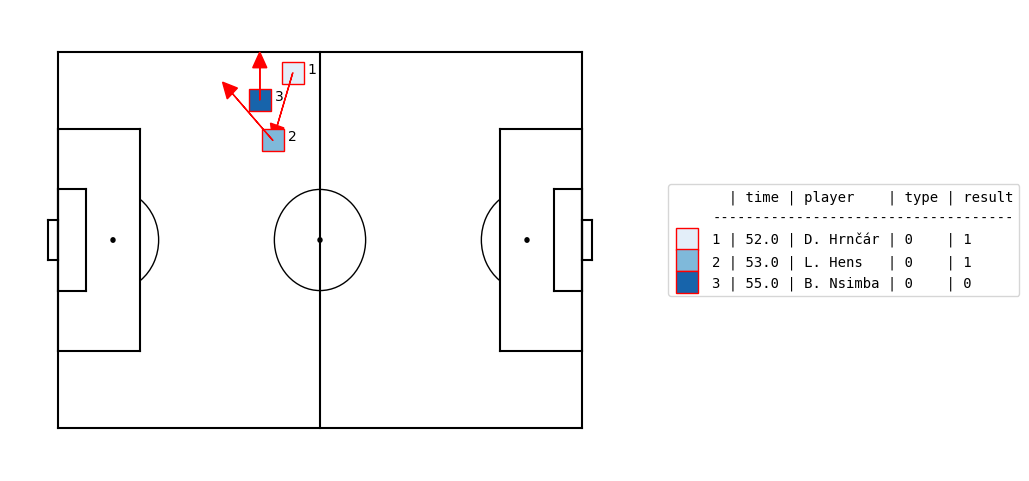

None

Loaded 3 actions


In [ ]:
import matplotsoccer

query = """
SELECT 
    s.id, 
    s.game_id, 
    s.period_id, 
    s.seconds, 
    s.team_id, 
    s.player_id, 
    s.action_type, 
    s.bodypart,
    s.start_x, 
    s.start_y, 
    s.end_x, 
    s.end_y, 
    s.result,
    p.player_name,
    t.team_name
FROM spadl_actions s
JOIN players p ON s.player_id = p.player_id
JOIN teams t ON s.team_id = t.team_id
WHERE s.game_id = '5uts2s7fl98clqz8uymaazehg'
ORDER BY s.id;
"""

spadl_df = pd.read_sql_query(query, conn)

spadl_actions = spadl_df[0:4]

ax = matplotsoccer.actions(
    location=spadl_actions[["start_x", "start_y", "end_x", "end_y"]],
    action_type=spadl_actions.action_type,
    team=spadl_actions.team_name,
    result=spadl_actions.result == "success",
    label= spadl_actions[["seconds", "player_name", "action_type", "result"]]
,
    labeltitle=["time", "player", "type", "result"],
    zoom=False,
    figsize=8,
)
display(ax)
print(f"Loaded {len(spadl_actions)} actions")

# the plot shows the actions in the order they are in the dataframe, so you can see how the game evolves over time.


In [39]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib as mpl

tracking_df = pd.read_sql_query(query, conn)
tracking_df.head()


,id,game_id,period_id,seconds,team_id,player_id,action_type,bodypart,start_x,start_y,end_x,end_y,result,player_name,team_name
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,8y3iucyxguipljcmf87a11bk9,60gs7lod7de72ypcs6qfup8q2,0,0,52.500,34.000,43.365,36.312,1,A. Guðjohnsen,Gent
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,8y3iucyxguipljcmf87a11bk9,18pgjfpl9s8qy32mblzygsyc5,21,0,43.365,36.312,48.720,34.680,1,S. Kums,Gent
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,8y3iucyxguipljcmf87a11bk9,18pgjfpl9s8qy32mblzygsyc5,0,0,48.720,34.680,45.150,50.184,1,S. Kums,Gent
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8y3iucyxguipljcmf87a11bk9,8fs5klbsyx06c5ds9s1i3xu96,0,0,46.200,48.008,39.270,63.376,1,Hong Hyun-Seok,Gent
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8y3iucyxguipljcmf87a11bk9,8kz0e83d3azssd7unbk2lqt0q,21,0,39.270,63.376,42.945,63.920,1,A. Brown,Gent


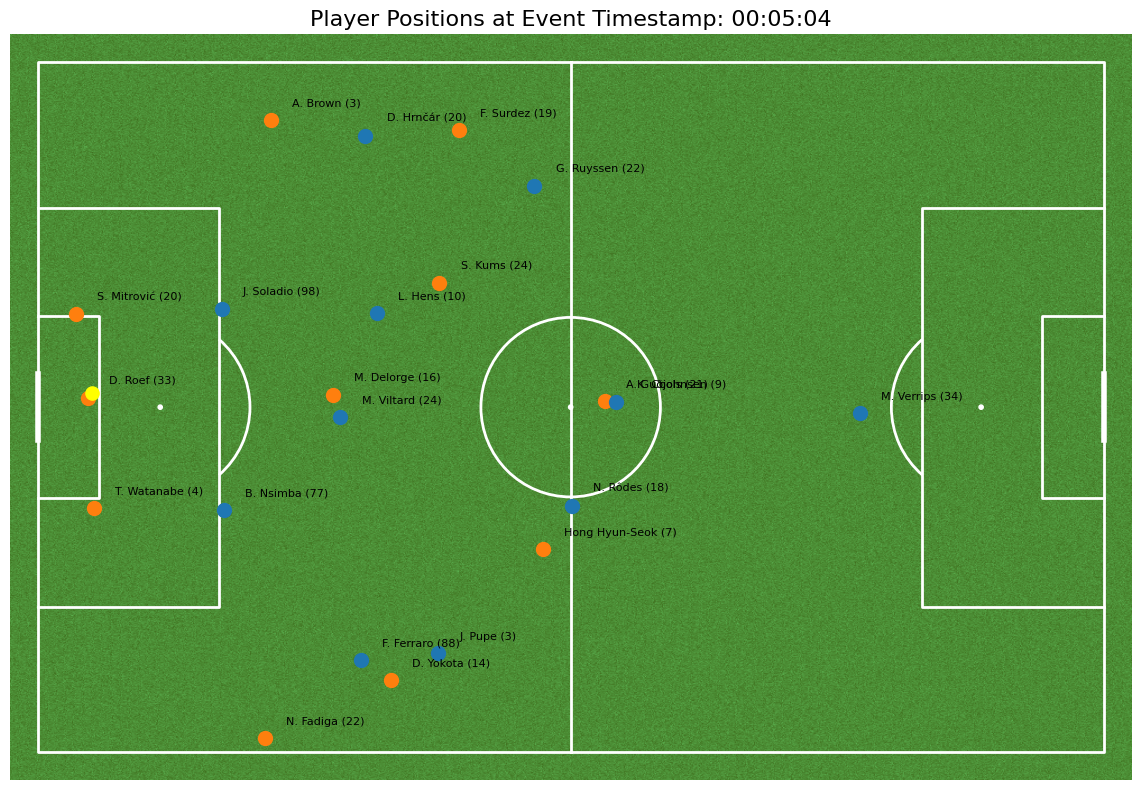

In [ ]:

def plot_tracking_data(tracking_data):
    # Define pitch dimensions and colors
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
                  pitch_length=105, pitch_width=68)  # Adjust dimensions if necessary
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Extract timestamp and team names
    timestamp = tracking_data['timestamp'].iloc[0]
    team_names = tracking_data['team_id'].unique()
    colors = mpl.colors.TABLEAU_COLORS
    color_map = {team: color for team, color in zip(team_names, colors.values())}
    
    # Plot player positions
    for _, row in tracking_data.iterrows():
        x = row['x']
        y = row['y']
        player_name = row['player_name']
        team_name = row['team_id']
        jersey_no = row['jersey_number']
        
        # Plot the ball
        if row['player_name'] == 'Ball':
            pitch.scatter(x, y, s=90, color='yellow', ax=ax, label='Ball')
        else:
            # Plot players
            pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax, label=team_name)
        
        # Add player names (excluding the ball)
        if row['player_name'] != 'Ball':
            ax.text(x + 2, y + 2, f"{player_name} ({jersey_no})", fontsize=8)
    
    # Set title
    ax.set_title(f'Player Positions at Event Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_tracking_data(filtered_tracking_df)